# Do short sellers respond to ESG ratings?

This notebook has been design as a reference guide of the cleaning and comparison process conducted in the project as well as some of the analysis performed.

Before starting the project, we will need to install the `wrds package`. We can do this by running `pip install wrds` in our terminal. For more information, refer to: https://pypi.org/project/wrds/. This package will be used for examining datasets on the Wharton Research Data Services (WRDS) platform, and extracting data to Pandas dataframes. A WRDS account is required, however since we are UChicago students we have access to this dataset already. The package is included in the requirements.txt for the project. 

In [1]:
import pandas as pd
import wrds
import config
from IPython.display import Image

Then, we generate the connection using our API information

In [2]:
WRDS_USERNAME = config.WRDS_USERNAME
db = wrds.Connection(wrds_username=WRDS_USERNAME)

Loading library list...
Done


## 1. Introduction

This project aims to investigate the intricate relationship between Environmental, Social, and Governance (ESG) events and securities lending activities. Our goal is to provide a nuanced understanding of the interplay between ESG considerations and market activities, offering valuable insights into the considerations of short sellers in the context of ESG events. At the heart of our inquiry lies the pivotal question: 

$$\textbf{Is there a relationship between ESG events and securities lending activity?}$$ 
$$\textbf{Do short sellers incorporate ESG events in their investment decisions?}$$

The relationship between Environmental, Social, and Governance (ESG) events and securities lending activities is a complex and multifaceted area of study within the financial market. The ESG events range from environmental disasters, social injustices, to governance failures—impact the behavior of short sellers and the broader securities lending market. 

#### Environmental Events

Environmental events can include incidents such as oil spills, deforestation, or emissions scandals. These events often lead to public backlash, regulatory scrutiny, and potentially significant financial impacts on the involved companies. Short sellers, anticipating a drop in stock prices due to these negative outcomes, may increase their activities. Consequently, the demand for borrowing shares of such companies may rise, affecting the securities lending market by increasing loan fees and utilization rates.

#### Social Events

Social events encompass issues like labor disputes, violations of human rights, and poor working conditions. These incidents can harm a company's reputation, leading to consumer boycotts or loss of investor confidence. Short sellers might view companies embroiled in social controversies as more likely to experience stock price declines, prompting an uptick in short selling activity. This dynamic can alter the supply-demand equilibrium in the securities lending market for the shares of the affected companies.

#### Governance Events

Governance events involve instances of poor management practices, corruption, executive misconduct, or lack of accountability. Such governance failures can erode investor trust and lead to financial penalties, impacting a company's stock performance. Short sellers often monitor these governance indicators as predictors of potential stock depreciation, influencing their investment strategies and, by extension, the securities lending market through variations in borrowing demand.

#### Securities Lending Market Dynamics

The Securities Lending Market is a crucial component of the financial markets, providing liquidity and facilitating the smooth functioning of securities trading. In this market, securities are temporarily transferred from one party to another. The lender of the securities, typically institutional investors like pension funds or mutual funds, loans out securities to borrowers, often for the purpose of short selling. The borrower, in return, provides collateral to the lender, which can be cash, other securities, or a letter of credit, and pays a fee based on an agreed-upon percentage of the loaned securities' value.

Market dynamics in securities lending are influenced by supply and demand for specific securities. High demand for borrowing certain securities can lead to higher lending fees, making it more profitable for lenders.

## 2. Financial Data Pulling 

To study this puzzling fact, we will refer to WRDS database. Wharton Research Data Services (WRDS) is a comprehensive repository of financial, economic, and insurance data. Renowned for its high-quality, reliable information, WRDS is indispensable for conducting precise financial analysis and research. Utilizing the WRDS platform, specifically through the wrds package, enables the swift and efficient extraction of large datasets. This efficiency in data collection affords researchers more time for in-depth analysis.

For this project, we have chosen to utilize multiple datasets from different libraries, including:

* The **RepRisk Library**, which evaluates environmental, social, and governance (ESG) risks, as well as business conduct, using an extensive array of public sources. The incident-based data encompasses a variety of issues such as environmental impacts, labor practices, human rights, supply chain management, corruption, legal disputes, and regulatory violations.

    Additionally, this dataset features the RepRisk Index (RRI), which dynamically captures and quantifies reputational risk exposure related to ESG issues. The RepRisk Rating (RRR), ranging from AAA to D, allows for the benchmarking and integration of ESG and business conduct risks.

* The **IHS Markit library** is a leading, global financial information services company with over 15,000 employees. The company provides independent data, valuations and trade processing across all asset classes in order to enhance transparency, reduce risk and improve operational efficiency.

We have also referred to a third database:

* The **CRSP (Center for Research in Security Prices) database** offers a historical perspective on stock prices, returns, and trading volumes, alongside crucial market indicators. For this study, the CRSP database is instrumental in furnishing the missing pieces of our dataset puzzle, especially in terms of shares outstanding. By leveraging CRSP data, we can accurately compute the financial ratios critical to our analysis. 

After thorough data cleaning, analysis, and comparison of the datasets mentioned above, the project will elucidate whether a relationship exists between ESG events and securities lending activities, offering insights into the considerations of short sellers regarding ESG events in their investment strategies.

### 2.1. Download and Read the data from RepRisk

As previously stated, we will start by importing the information from the `company_identifiers` table from the RepRisk library using a database connection object. This table contains identifiers for companies analyzed, providing essential data for researching company-specific environmental, social, and governance (ESG) risks.

In [3]:
# RepRisk - Company Identifiers
RepRisk_company_identifiers = db.get_table(library='reprisk', table='v2_company_identifiers', obs=10)
RepRisk_company_identifiers.head()

,reprisk_id,company_name,headquarters_country,headquarters_country_isocode,sectors,url,isins,primary_isin,no_reported_risk_exposure
0,10,Acer Inc,Taiwan,TW,Technology Hardware and Equipment,https://www.acer.com,US0044341065 | US0044342055 | TW0002353000,TW0002353000,false
1,100,Rio Tinto PLC,United Kingdom of Great Britain and Northern I...,GB,Mining,https://www.riotinto.com/,GB0007406639 | BRRIOTBDR007 | ARDEUT112638 | G...,GB0007188757,false
2,1000,Terrane Metals Corp,Canada,CA,Mining,terranemetals.com,CA88103A1167 | US88103A3068 | CA88103A1084 | C...,CA88103A1084,false
3,10000,RAK Properties PJSC,United Arab Emirates,AE,Financial Services,https://www.rakproperties.ae/,AER000601016,AER000601016,true
4,100000,BLUECOM Co Ltd,"Korea, the Republic of (South Korea)",KR,Technology Hardware and Equipment,http://www.bluec.co.kr/eng/,KR7033560004,KR7033560004,false


From the `company_identifiers` table the following variables will be extracted:

1. reprisk_id (COMAPNY ID)
2. company_name	(COMPANY Name)
3. headquarters_country	(Headquarters Country)
4. headquarters_country_isocode	(Headquarters Country ISO Code)
5. sectors (Sector(s))
6. url (URL)
7. isins (Isin(s))
8. primary_isin	(Primary ISIN)
9. no_reported_risk_exposure (No reported risk exposure) 

From the Reprisk database, we will also import the `risk_incidents` table which has compiling information on various risk incidents since 2007. This dataset is notably large, encompassing an array of metrics that exceed the requirements of this project. To streamline the dataset and enhance its efficiency, we will refine our focus to a select group of columns. Specifically, we will retain only the following columns: *reprisk_id, story_id, incident_date, unsharp_incident, related_countries, related_countries_codes, severity, reach, novelty, environment, social, and governance*.

In [4]:
# RepRisk - Risk Incidents available since 2007
RepRisk_risk_incidents = db.get_table(library='reprisk', table='v2_risk_incidents', obs=10)
RepRisk_risk_incidents.head()

,reprisk_id,story_id,incident_date,unsharp_incident,related_countries,related_countries_codes,severity,reach,novelty,environment,...,ungc_principle_1,ungc_principle_2,ungc_principle_3,ungc_principle_4,ungc_principle_5,ungc_principle_6,ungc_principle_7,ungc_principle_8,ungc_principle_9,ungc_principle_10
0,10,826,2007-02-28,0,China,CN,2,2,1,F,...,F,F,F,F,F,F,F,F,F,F
1,10,1793,2007-09-09,0,Germany,DE,1,2,1,F,...,F,F,F,F,F,F,F,F,F,F
2,10,2335,2007-11-26,0,Unspecified,None,1,2,1,F,...,F,F,F,F,F,F,F,F,F,F
3,10,2365,2007-08-21,1,China,CN,2,1,2,F,...,T,T,F,F,T,F,F,F,F,F
4,10,2513,2007-11-30,0,Russian Federation;South Africa,RU;ZA,1,1,2,F,...,T,F,F,F,F,F,F,F,F,F


From the `risk_incidents` table the following variables will be extracted:

1. company_name	(COMPANY Name)
2. headquarters_country_isocode	(Headquarters Country ISO Code)
3. primary_isin	(Primary ISIN)
4. reprisk_id (Reprisk Company ID)
5. story_id	(Story ID)
6. incident_date (Incident Date)
7. unsharp_incident	(Unsharp Incident)
8. related_countries (Related Countries)
9. related_countries_codes (Related Countries Codes)
10. severity (Severity)
11. reach (Reach)
12. novelty	(Novelty)
13. environment	(ENVIRONMENT)
14. social (SOCIAL)
15. governance (GOVERNANCE)

Finally, we will import the `metrics` table from the Reprisk library. Out of all the metrics available, we will only focus on :

* The *Current RRI* denotes the current level of media and stakeholder attention of a company related to ESG issues.
* The *Trend RRI* states the difference in the RepRisk Index (RRI) between current date and the date 30 days ago.
* The *RepRisk Rating RRR* facilitates corporate benchmarking against a peer group and the sector, as well as integration of ESG and business conduct risks into business processes. It combines the company-specific ESG risk exposure (provided by the Peak RRI) and the Country-Sector ESG risk exposure (provided by the Country-Sector Average value of a company).

In [5]:
# RepRisk - Metrics available since 2007
RepRisk_metrics = db.get_table(library='reprisk', table='v2_metrics', obs=10)
RepRisk_metrics.head()

,reprisk_id,date,current_rri,trend_rri,peak_rri,peak_rri_date,reprisk_rating,country_sector_average,principle1_human_rights,principle2_human_rights,principle3_labour,principle4_labour,principle5_labour,principle6_labour,principle7_environment,principle8_environment,principle9_environment,principle10_anti_corruption
0,2273005,2020-01-05,0,0,0,None,AA,21,None,None,None,None,None,None,None,None,None,None
1,2273005,2020-01-06,0,0,0,None,AA,21,None,None,None,None,None,None,None,None,None,None
2,2273005,2020-01-07,0,0,0,None,AA,21,None,None,None,None,None,None,None,None,None,None
3,2273005,2020-01-08,0,0,0,None,AA,21,None,None,None,None,None,None,None,None,None,None
4,2273005,2020-01-09,0,0,0,None,AA,21,None,None,None,None,None,None,None,None,None,None


From the `metrics` table the following variables will be extracted:

1. company_name	(COMPANY Name)
2. headquarters_country_isocode	(Headquarters Country ISO Code)
3. primary_isin	(Primary ISIN)
4. reprisk_id (RepRisk COMPANY ID)
5. date	(Date)
6. current_rri (Current RRI)
7. trend_rri (Trend RRI)
8. peak_rri	(Peak RRI)
9. peak_rri_date (Peak RRI Date)
10. reprisk_rating (RepRisk Rating)

The three previous Reprisk tables will be extracted under the same SQL query since they belong to the same library. Furthermore, they will be joined using the `reprisk_id`, a unique identifier available in each table. 

The extraction and loading process is managed by `load_reprisk.py` a Python script designed for efficient data retrieval. 

In [6]:
from load_reprisk import load_RepRisk

reprisk_df = load_RepRisk()
reprisk_df.head()

Loading library list...
Done


,reprisk_id,date,company_name,primary_isin,current_rri,trend_rri,peak_rri,peak_rri_date,reprisk_rating,country_sector_average,...,unsharp_incident,related_countries,related_countries_codes,severity,reach,novelty,environment,social,governance,cusip
0,10,2022-01-01,Acer Inc,TW0002353000,20,-2,34,2020-04-04,BB,42,...,NaN,None,None,NaN,NaN,NaN,None,None,None,000235300
1,10,2022-01-02,Acer Inc,TW0002353000,20,-2,34,2020-04-04,BB,42,...,NaN,None,None,NaN,NaN,NaN,None,None,None,000235300
2,10,2022-01-03,Acer Inc,TW0002353000,20,-2,34,2020-04-04,BB,42,...,NaN,None,None,NaN,NaN,NaN,None,None,None,000235300
3,10,2022-01-04,Acer Inc,TW0002353000,20,-2,34,2020-04-04,BB,42,...,NaN,None,None,NaN,NaN,NaN,None,None,None,000235300
4,10,2022-01-05,Acer Inc,TW0002353000,20,-2,34,2020-04-04,BB,42,...,NaN,None,None,NaN,NaN,NaN,None,None,None,000235300


### 2.2. Download and Read the data from Markit

The next step is to download the data from the Markit Securities database. Initially, the data was going to get extracted from the American Equities table know as `msfaamer`, however, after checking the available tables under the `msfanly` library, we discovered is not longer available, and neither is in the `markit_msf_analytics_eqty_amer` library. So the only feasible workaround is extract the Markit data year by year instead from the `amereqty` table. 

You will find the code that extracts the data for the multiple years and load it into the system in the file called `load_markit.py`.

In [7]:
MarkitSecurities_american_equities_2024 = db.get_table(library='msfanly', table='amereqty2024', obs=10)
MarkitSecurities_american_equities_2024.head()

,datadate,dxlid,isin,sedol,cusip,quick,instrumentname,marketarea,valueonloan,quantityonloan,...,lendablequantitystability,lendablevaluestability,lenderquantityonloanstability,lendervalueonloanstability,indicativefee1day,indicativefee7day,indicativerebate1day,indicativerebate7day,saf,sar
0,2024-01-01,DX00000021,US98956P1021,2783815,98956P102,None,Zimmer Biomet Holdings Inc,US Equity (S&P500),227014800.0,1855436.0,...,74.12062,74.08830,52.82086,52.82014,None,0.002162,None,0.051038,56.3462,475.6539
1,2024-01-01,DX00000023,US7901481009,2768663,790148100,None,St Joe Co,US Equity (RUSSELL 2000),13916060.0,229522.0,...,83.24494,83.28563,71.45999,71.46178,None,0.002615,None,0.050585,77.8825,454.1175
2,2024-01-01,DX00000026,US6934751057,2692665,693475105,None,Pnc Financial Services Group Inc,US Equity (S&P500),978845200.0,6262167.0,...,77.79643,77.79671,78.85870,78.82349,None,0.002810,None,0.050390,52.4547,479.5453
3,2024-01-01,DX00000029,US6516391066,2636607,651639106,None,Newmont Corporation,US Equity (S&P500),352309900.0,8448317.0,...,87.88121,87.88775,94.43805,94.39819,None,0.002624,None,0.050576,38.5648,493.4352
4,2024-01-01,DX00000030,US5951121038,2588184,595112103,None,Micron Technology Inc,US Equity (S&P500),232887600.0,2693965.0,...,74.48444,74.49966,71.63672,71.67267,None,0.002648,None,0.050552,53.7643,478.2357


From the `amereqty` table the following variables will be extracted:

1. datadate	(Date)
2. dxliD (DataExplorer ID)
3. isin	(Primary ISIN)
4. sedol (Stock Exchange Daily Official List number)
5. cusip (Committee on Uniform Securities Identification Procedures number)
6. instrumentname (Financial Instrument Name)
7. indicativefee (Indicative Fee)
8. utilisation	(Utilisation)
9. shortloanquantity (Short On Loan Quantity)
10. quantityonloan (Quantity On Loan)
11. lendablequantity (Lendable Quantity)
12. lenderconcentration (Lender Concentration)
13. borrowerconcentration (Borrower Concentration)
14. inventoryconcentration (Inventory Concentration)

The same way we implemented the `load_reprisk.py` file, we create a `load_markit.py` that is going to pull data from WRDS for the different tables of Markit (each year is contained in a different table) and concatenate everything.

In [8]:
from load_markit import load_Markit

markit_df = load_Markit()
markit_df.head()

Loading library list...
Done
Pulling data for year 2022
Pulling data for year 2023
Pulling data for year 2024


,datadate,cusip,isin,instrumentname,indicativefee,utilisation,shortloanquantity,quantityonloan,lendablequantity,lenderconcentration,borrowerconcentration,inventoryconcentration,marketarea,cusip8
0,2022-01-03,98956P102,US98956P1021,Zimmer Biomet Holdings Inc,0.003046,0.940322,841097.0,1529768.0,97650856.0,0.385752,0.194563,0.130224,US Equity (S&P500),98956P10
1,2022-01-03,790148100,US7901481009,St Joe Co,0.002948,4.205225,764058.0,764058.0,15916389.0,0.306246,0.219257,0.213042,US Equity (RUSSELL 2000),79014810
2,2022-01-03,693475105,US6934751057,Pnc Financial Services Group Inc,0.003151,1.323707,3015056.0,3419061.0,193419648.0,0.216715,0.233506,0.155540,US Equity (S&P500),69347510
3,2022-01-03,651639106,US6516391066,Newmont Corporation,0.003342,1.591628,5968277.0,6130376.0,340623712.0,0.121905,0.148309,0.146164,US Equity (S&P500),65163910
4,2022-01-03,595112103,US5951121038,Micron Technology Inc,0.001814,0.926157,3526685.0,8491586.0,501146144.0,0.272535,0.133312,0.132156,US Equity (S&P500),59511210


### 2.3. Download and Read the data from CRSP

Unfortunatelly, not all the required data to compute the ratios can be extracted from the two previous libraries, specially the data regarding outstanding shares, hence we will need to download data from CRSP (Center for Research in Security Prices) database for a specified date range. 

To ensure compatibility with the other imported datasets, we will need to compute the CUSIP id. This number is very useful for linking purposes and can be computed combining the CRSP identifiers permno, permco, cusip (columns that will be imported). Then, we will join this crspid table with the MSF identifiers through the common historical CUSIP link. For more information, refer to https://wrds-www.wharton.upenn.edu/pages/wrds-research/database-linking-matrix/linking-markit-with-crsp-2/#connecting-with-crsp

The extraction will be done through wrd pacakge, using the `crspq.stksecurityinfohist` library. You will find the code that extracts this data and loads in the file called `load_crps.py`.

In [9]:
# CRSP Daily Stock available since 1925

CRSP_daily_stock = db.get_table(library='crspq', table='dsf', columns=['cusip', 'date', 'permco', 'permno', 'shrout'], obs=10)
CRSP_daily_stock.head()

,cusip,date,permco,permno,shrout
0,68391610,1986-01-07,7952,10000,3680.0
1,68391610,1986-01-08,7952,10000,3680.0
2,68391610,1986-01-09,7952,10000,3680.0
3,68391610,1986-01-10,7952,10000,3680.0
4,68391610,1986-01-13,7952,10000,3680.0


From the `dsf` table the following variables will be extracted:

1. date (Date)
2. permno
3. permco
4. cusip
5. shrout (Shares Outstanding)

In [10]:
from load_crsp import load_CRSP

crsp_df = load_CRSP()
crsp_df.head()

Loading library list...
Done


,cusip9,date,cusip8,shrout
0,00032Q104,2022-01-03,00032Q10,20895000.0
1,00032Q104,2022-01-04,00032Q10,20895000.0
2,00032Q104,2022-01-05,00032Q10,20895000.0
3,00032Q104,2022-01-06,00032Q10,20895000.0
4,00032Q104,2022-01-07,00032Q10,20895000.0


## 3. Data Manipulation

### 3.1. Data Merging

The data merging operation was structured in two distinct phases to bolster the accuracy and reliability of the data integration process, ensuring that data correlations consistent. Initially, the process focused on the integration of Markit data with the CRSP (Center for Research in Security Prices) database and after its successful amalgamation, the second phase introduced the integration of Reprisk data, a strategic move designed to enrich the dataset with environmental, social, and governance (ESG) risk assessments. 

Each step in the process is executed with precision, leveraging custom-designed functions to guarantee that the integration not only maintains data integrity but also optimizes the dataset for nuanced analysis, avoiding data repetition or missing values. 


#### 3.1.1. Merging Markit - CRSP  

The `merge_markit_crsp.py` module facilitates the merging of Markit and CRSP datasets by aligning them on dates and CUSIP8 identifiers. This merging process results in a unified table that inherently includes all the necessary details to calculate key financial ratios, so instead of creating another function that returns the required ratios, the function itself enriches the dataset by appending four additional columns, which represent the short interest, loan supply, loan utilisation, and loan fees ratios.

For the incorporation of RepRisk data alongside these datasets, WRDS suggests prioritizing the ISIN number for matching purposes with CUSIP. Nonetheless, given the notable occurrence of missing ISIN numbers within the RepRisk dataset, a fallback strategy involves matching based on company names. 


#### 3.1.2. Merging Markit - CRSP - RepRisk

The `merge_markit_crsp_reprisk.py` module contain the function designed to integrate a pre-merged Markit and CRSP dataframe with a Reprisk dataframe, based on shared 'cusip' and 'date' fields.

In [11]:
from merge_markit_crsp import merge_markit_crsp
from merge_markit_crsp_reprisk import merge_data

merged_markit_crsp = merge_markit_crsp(markit_df, crsp_df)

merged_df = merge_data(merged_markit_crsp, reprisk_df)
merged_df.head()

,date,cusip,isin,instrumentname,indicativefee,utilisation,shortloanquantity,quantityonloan,lendablequantity,lenderconcentration,...,story_id,unsharp_incident,related_countries,related_countries_codes,severity,reach,novelty,environment,social,governance
0,2022-01-03,98956P102,US98956P1021,Zimmer Biomet Holdings Inc,0.003046,0.940322,841097.0,1529768.0,97650856.0,0.385752,...,NaN,NaN,None,None,NaN,NaN,NaN,None,None,None
1,2022-01-03,790148100,US7901481009,St Joe Co,0.002948,4.205225,764058.0,764058.0,15916389.0,0.306246,...,NaN,NaN,None,None,NaN,NaN,NaN,None,None,None
2,2022-01-03,693475105,US6934751057,Pnc Financial Services Group Inc,0.003151,1.323707,3015056.0,3419061.0,193419648.0,0.216715,...,NaN,NaN,None,None,NaN,NaN,NaN,None,None,None
3,2022-01-03,651639106,US6516391066,Newmont Corporation,0.003342,1.591628,5968277.0,6130376.0,340623712.0,0.121905,...,NaN,NaN,None,None,NaN,NaN,NaN,None,None,None
4,2022-01-03,595112103,US5951121038,Micron Technology Inc,0.001814,0.926157,3526685.0,8491586.0,501146144.0,0.272535,...,NaN,NaN,None,None,NaN,NaN,NaN,None,None,None


### 3.2. Select the desired subsample of the data

In order to be able to run the code easily without waiting too much for the different pulling and merging steps, we will be working on the period from January 2022 to January 2024. To change that period, it suffices to change the dates in `config.py`.

## 4. Construct new metrics

### 4.1. Ratios

This project aims to empirically examine whether there is a quantifiable relationship between ESG events and changes in securities lending activity, such as variations in short interest ratios, loan supply ratios, and loan fees. By analyzing data on ESG incidents and securities lending metrics, the study seeks to determine if and how short sellers incorporate ESG considerations into their investment decisions, potentially using ESG events as indicators to guide their short-selling strategies. 

In the realm of securities lending, several key metrics are pivotal for assessing market dynamics and investor sentiment. Below, we delve into the critical ratios and explore additional variables of interest within the Markit dataset.

#### Key Ratios

1. **Short Interest Ratio**: This ratio indicates the proportion of shares that are currently borrowed for short selling compared to the total shares outstanding. A higher ratio suggests a more significant interest in short selling the stock, potentially indicating bearish market sentiment towards the company.

   $$\text{Short Interest Ratio} = \frac{\text{Shares on Loan}}{\text{Shares Outstanding}} \quad \text{or} \quad \frac{\text{QuantityOnLoan}}{\text{SHROUT}}$$

2. **Loan Supply Ratio**: This metric measures the availability of shares for lending against the total shares outstanding. It reflects the willingness of shareholders to lend their shares for short selling, indicating the liquidity and accessibility of shares for short sellers.

   $$\text{Loan Supply Ratio} = \frac{\text{Shares Available to be Lent}}{\text{Shares Outstanding}} \quad \text{or} \quad \frac{\text{LendableQuantity}}{\text{SHROUT}}$$

3. **Loan Utilization Ratio**: This ratio compares the demand to the supply of loanable shares. A higher utilization rate suggests a strong demand for borrowing shares, often associated with an increased short selling activity.

   $$\text{Loan Utilization Ratio} = \text{Utilisation}$$

4. **Loan Fee**: The indicative fee associated with borrowing shares. This fee can vary based on the demand and supply dynamics of the loanable shares, acting as a cost indicator for short sellers.

   $$\text{Loan Fee} = \text{IndicativeFee}$$

#### Additional Variables of Interest in Markit

- **LenderConcentration**: Measures the concentration of shares being lent by a small number of lenders. A higher concentration could indicate a less competitive lending market, potentially affecting loan fees and availability.

- **BorrowerConcentration**: Reflects the concentration of shares borrowed by a small number of borrowers. This can highlight the dependency on certain borrowers and potential risks associated with borrower default.

- **InventoryConcentration**: Indicates the concentration of shares available for lending held by a few entities. High concentration may suggest potential manipulation or control over the lending market by a limited number of participants.

Exploring these ratios and variables provides a comprehensive view of the securities lending market, offering insights into short selling trends, market sentiment, and the operational dynamics of the lending ecosystem.

The ratios are being calculated in `merge_markit_crsp.py` after the first merge providing the variable for the shares outstanding, available exclusively in CRSP.

### 4.2. Summary statistics

For the summary statistics part, we have computed the following metrics:

Some of the chosen metrics have been `quantiles` which are cut points dividing the range of a probability distribution into continuous intervals with equal probabilities

* 10% quantile  
* 25% quantile
* 50% quantile (or median)  
* 75% quantile  
* 90% quantile  

We have also computed the `mean`, so the average of a data set, the `standard deviation`, to measure of how dispersed the data is in relation to the mean and finally the `count`, so the amount of data points analyzed.

A table has been generated for each ratio against each level of ESG incident (severity / novelty / news reach / Environmental / Social / Governance)

In [ ]:
from compute_desc_stats import compute_desc_stats

_ = compute_desc_stats(merged_df)

`compute_desc_stats.py` will create the different summary statistics and store each dataframe that will later be used in order to create LaTeX tables displayed in the final report. Let's see an example of such table.

In [16]:
short_interest_ratio_severity = pd.read_parquet(r"../output/stats/short interest ratio_severity.parquet")
short_interest_ratio_severity

,count,mean,std,min,10%,25%,50%,75%,90%,max
severity,,,,,,,,,,
1.0,6099.0,1.734169,3.700427,1.662433e-08,0.083070,0.175604,0.445760,1.540173,4.508220,46.570113
2.0,1576.0,1.744126,3.331584,1.662433e-08,0.079428,0.184644,0.557390,1.833086,4.512307,40.320882
3.0,305.0,1.133819,1.694918,1.662433e-08,0.069699,0.171051,0.554853,1.283257,2.955818,13.216340


In this table we are looking at the summary statistics for the Short Interest Ratio while controlling for severity of the ESG risk incident for the entire universe of stocks. That is, a function of the consequences of the severity with respect to ESG issues, the extent of its impact, and its type.

As we would expect, the lower the severity level, the higher the amount of observations for the Short Interest Ratio.

However, when it comes to the mean of the ESG incidents, we re getting counter intuitive results. The results show that the higher the incident severity, the lower the mean Short Interest ratio. This is an interesting result that can have further investigations.

A similar result is found for the standard deviation, the higher the severity, the lower the standard deviation. This is also an interesting result that can have further investigations.

It is interesting to highlight that the highest Short Interest Ratio achieved by any company in the dataframe was achieved when a company had an incident of severity level 1 and it was of 46.57%. That means, almost half of the available stocks were being borrowed for short selling in that moment.

In [18]:
loan_utilisation_ratio_environment = pd.read_parquet(r"../output/stats/loan utilisation ratio_environment.parquet")
loan_utilisation_ratio_environment

,count,mean,std,min,10%,25%,50%,75%,90%,max
environment,,,,,,,,,,
F,5623.0,5.943967,13.663773,0.0,0.162764,0.369501,0.976583,4.479601,15.076378,100.00000
T,2481.0,6.953582,14.333671,0.0,0.155435,0.451127,1.605360,5.965334,19.890620,99.11085


As described in the RepRisk data documentation, the core research scope of RepRisk comprises 28 ESG Issues, which are divided into environmental, social, governance, and cross- sectional issues. Specifically, the Environment data element reflects T if the risk incident is linked to an environmental issue, else F.

Therefore, in this case we can appreciate how the maximum Loan Utilisation Ratio achieved by any company when an Enivornmental incident happened was 99.11%, while when no incident happened, the maximum was 100%.

Moreover, we see an increas in the mean Loan Utilisation ratio when there occurs an environmental incident, which is a result that favors the thesis that there is an impact in lending metrics when an ESG incident happens.

The meedian of the Loan Utilisation ratio gives us another argument in favor of the thesis explored in this project. We can see an increase from 0.97% when there is No Environmental incident to 1.61% when there is an Environmental incident.

Therefore, these results provoke further investigation and analysis to understand the relationship between Environmental incidents and the Loan Utilisation Ratio.

### 4.3. An example: Apple

Now that we were able to compute the different ratios and come up with summary statistics for each level of ESG incident, we can take a look at a company in particular. In this example, we look at APPLE.

In [ ]:
from plot_lend_ind import plot_lend_ind

cusip_list = ['037833100', '36467W109','02209S103']
name_list = ['Apple Inc', 'GameStop Corp', 'Altria Group Inc']

_ = plot_lend_ind(merged_df, cusip_list, name_list)

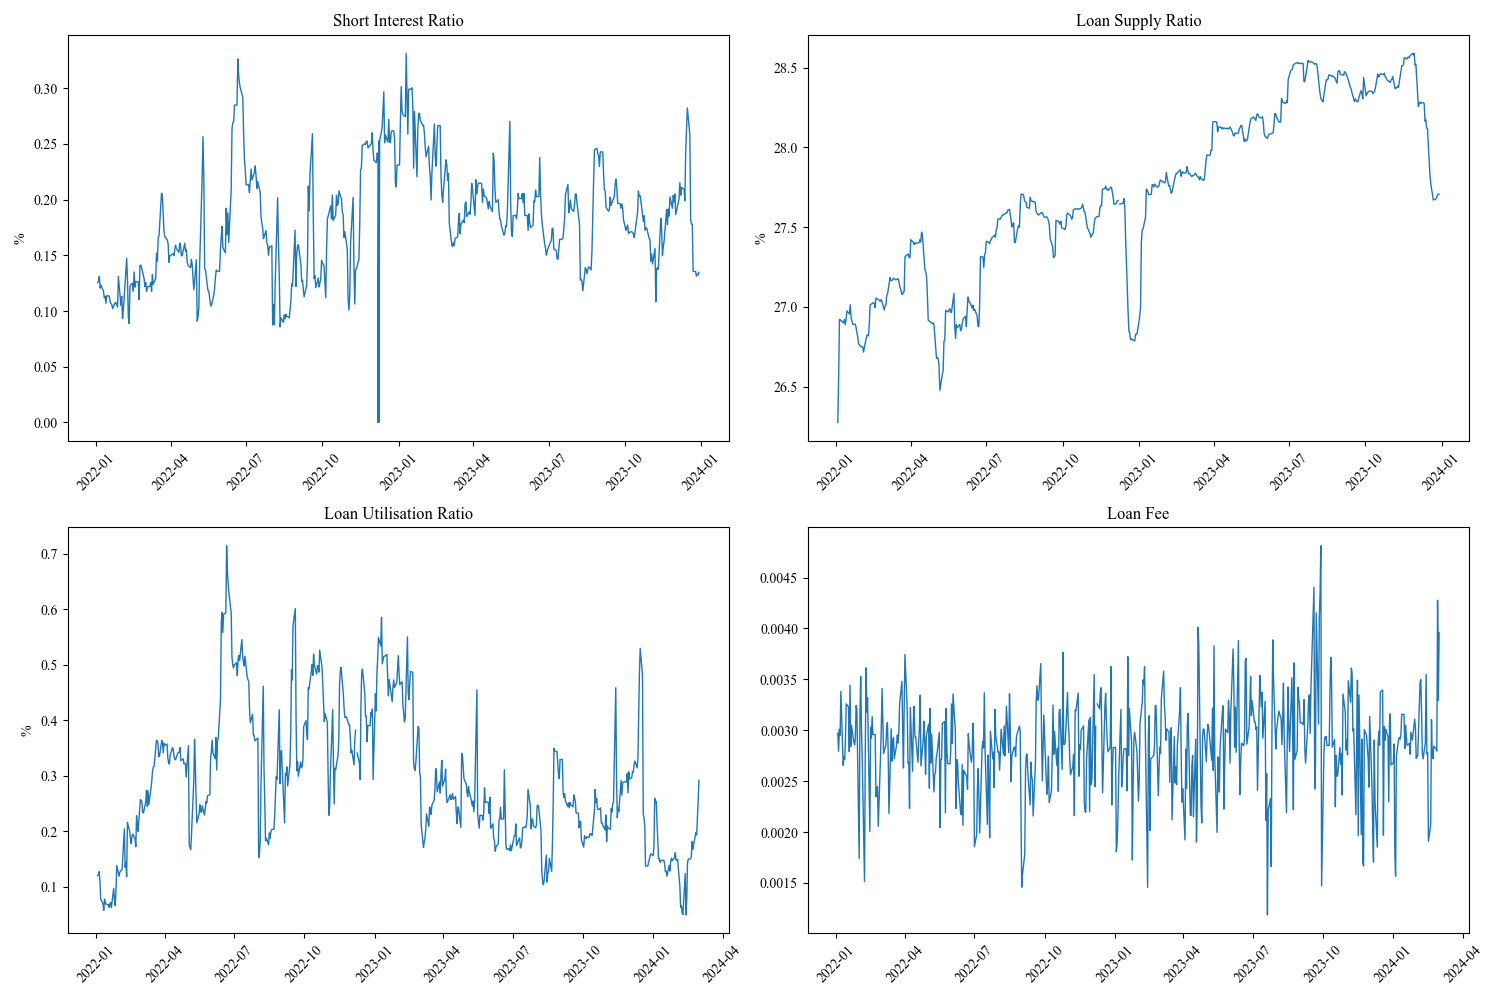

In [20]:
# import graphs from the output folder
display(Image(filename='../output/Apple Inc_lend_ind.png'))

Apple Inc. is a company that designs, produces and commercializes electronic products. We are going to analyze the evolution of Apple's Lending Metrics since as of March 2024, it was the second largest valued company in the US Stock market, just below Microsoft Inc that surpassed it in January of the same year.

Therefore, we can categorize this company as a 'mega cap' company, and an in-between on growth and core in terms of it's categorization in terms of Price to Earnings ratio and other indicators used to build that categorization. For this type of stocks, it is important to note that Short Sellers usually don't have enough market participation in terms of the total shares outstanding to impose important pressures on determining the stock's price.

Let's break down the analysis of the previous plot into each subplot.

* **Short Interest Ratio:** While displaying moderate fluctuations, has notable inflections that may correspond with ESG-related events. These changes imply a varying degree of shareholder willingness to lend out shares for short selling, potentially reflecting a higher liquidity or investor confidence.
* **Loan Supply Ratio:** It can be noted that it remains relatively stable over the observed period and with a tendency to the upside, suggesting a consistent availability of Apple's shares for lending. This stability is indicative of that significant changes in shares outstanding are uncommon, not generating high spikes in short selling. However, the movements within the ratio may reflect strategic financial decisions by the company, such as share buybacks or issuance of new shares, which can affect the numerator and denominator of the ratio respectively.
* **Loan Utilisation Ratio:** It can be noted the higher volatility it displays when compared with the other indicators, with pronounced peaks suggesting moments of increased demand for borrowing shares. These peaks are often aligned with short-selling activities, where investors anticipate a decline in stock prices. Further studies can be done on the relationship between this peaks and valleys and wether they are caused by the usual market events such as earnings reports, product launches, or publications of macroeconomic indicators or ESG-releted events.
* **Loan Fee Ratio:** For Apple Inc, this is the indicator that seems the most stationary at first look. However, out of all of the ratios computed for Apple Inc, the loan fee seems to follow a process similar to a random walk, with no clear trend or seasonality.

## 5. Conclusion

In conclusion, we have examined the intricate relationship between ESG incidents and the landscape of securities lending, focusing on specific lending metrics for the US Stock Market. The project harnessed a rich array of data, merging intricate datasets from the likes of WRDS — including RepRisk, IHS Markit, and CRSP — to construct a robust analytical framework. Despite the hurdles of data integration, the study provided compelling insights into the conduct of short sellers in the face of ESG events.

The analysis yielded clear indications that ESG developments have a tangible impact on securities lending, evidenced by the variations in the Short Interest Ratio amidst ESG incidents. The data definitely gives some insights on the responsiveness of short sellers to ESG-related news, and opens some interesting fields for further study of these computed metrics and any other metric that would give more information on the behavior of short sellers in the US Stock Market.

Contrasting behaviors emerged when examining the lending indicators of distinct companies like Apple Inc., GameStop Corp., and Altria Group Inc. This contrast is particularly illuminating, as it highlights how company-specific factors — such as industry segment, market size, and the nature of ESG controversies — are reflected in securities lending metrics.

While the research has indeed cast light on the relationship between ESG events and market reactions, it is not without its limitations. The study's observational design and the vast spectrum of ESG incidents considered make it challenging to draw definitive conclusions about causation. Furthermore, the fast-paced evolution of both ESG reporting standards and market sentiment presents an ever-shifting landscape that this study could only snapshot.

In summation, this research underscores the growing importance of ESG considerations in the financial domain, especially concerning the actions of short sellers in the securities lending market. It lays the groundwork for further academic inquiry and suggests a future direction where further studies and more sophisticated econometric techniques might unravel the complex web of causality that underpins the observed market behaviors.

***